# CATS analysis

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
#Data loading
data = pd.read_csv("data/Train_call.txt", sep='\t')

In [3]:
data

,Chromosome,Start,End,Nclone,Array.129,Array.34,Array.67,Array.24,Array.22,Array.36,...,Array.64,Array.89,Array.30,Array.35,Array.93,Array.10,Array.123,Array.100,Array.134,Array.130
0,1,2927,43870,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
1,1,85022,216735,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
2,1,370546,372295,4,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,-1,0
3,1,471671,786483,5,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
4,1,792533,907406,13,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,23,153062077,153452633,57,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2830,23,153466463,153491568,4,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2831,23,153504394,153933426,55,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1
2832,23,153938998,153989329,5,1,1,1,0,1,1,...,2,1,1,1,1,1,1,1,1,1


Dropping the columns we don't need:

In [4]:
data.drop(['Chromosome'], axis=1, inplace=True)
data.drop(['Start'], axis=1, inplace=True)
data.drop(['End'], axis=1, inplace=True)
data.drop(['Nclone'], axis=1, inplace=True)

Transposing because the instances are in the columns and the features in the row and we need the opposite:

In [5]:
data = data.T

Loading the target:

In [6]:
y = pd.read_csv("data/Train_clinical.txt", sep='\t', low_memory=False)

In [7]:
y

,Sample,Subgroup
0,Array.129,HER2+
1,Array.34,HR+
2,Array.67,HR+
3,Array.24,Triple Neg
4,Array.22,Triple Neg
...,...,...
95,Array.10,HER2+
96,Array.123,HR+
97,Array.100,HR+
98,Array.134,HR+


 Dropping the column we don't need and making it the proper dimensions:

In [8]:
y.drop(['Sample'], axis=1, inplace=True)
y=np.squeeze(y)

Splitting train and test data (we won't need this once they provide the test data):

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.3, random_state=4)

## Random Forest

In [10]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
def rf_model(X, y, n_estimators_list, max_depth_list, min_samples_split_list, min_samples_leaf_list):
    # Setup the Grid Search function with parameters given by the user
    grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state = 0),
                              param_grid = {'n_estimators': n_estimators_list,
                                           'max_depth': max_depth_list,
                                           'min_samples_split': min_samples_split_list,
                                           'min_samples_leaf': min_samples_leaf_list,},
                              scoring = "accuracy",
                              verbose = 0,
                              cv = 5)
    # Run the grid search
    gs_results= grid_search.fit(X, y)
    # Get the best parameters
    gs_bp = gs_results.best_params_
    
    rf = RandomForestClassifier(n_estimators = gs_bp["n_estimators"],
                                max_depth = gs_bp["max_depth"],
                                min_samples_split = gs_bp["min_samples_split"],
                                min_samples_leaf = gs_bp["min_samples_leaf"],
                                random_state = 0,
                                verbose = False)
    # Get scores:
    scores = cross_val_score(rf, X, y, cv = 5, scoring = "accuracy")
    
    return gs_results, gs_bp, rf, scores

In [13]:
# Initialize parameters to test for the random forest model
# Number of estimators should be a list of values
n_estimators_list = [50, 250, 750]
# Max depth should be a range of integers
max_depth_list = range(2,10,3)
# Should be  alist of integers
min_samples_split_list = [2, 6]
min_samples_leaf_list = [1, 5, 10]

In [14]:
%%time
gs_rf_results, gs_rf_bp, rf, rf_scores = rf_model(x_train, y_train, n_estimators_list, max_depth_list, 
                                              min_samples_split_list, min_samples_leaf_list)

Wall time: 1min 34s


In [15]:
print("Cross-validation accuracies: ") 
print(np.mean(rf_scores))

Cross-validation accuracies: 
0.7142857142857142


In [16]:
rf.fit(x_train,y_train)
                            
# Model Accuracy, how often is the classifier correct?
train_rf_pred=rf.predict(x_train)
# Evaluate training accuracy
test_rf_pred=rf.predict(x_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy training:",metrics.accuracy_score(y_train, train_rf_pred))
print("Accuracy testing:",metrics.accuracy_score(y_test, test_rf_pred))

Accuracy training: 1.0
Accuracy testing: 0.7666666666666667


In [17]:
cf_matrix=metrics.confusion_matrix(y_test, test_rf_pred, labels=["HER2+", "HR+", "Triple Neg"])

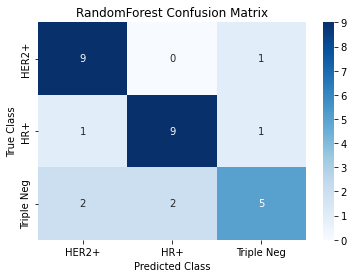

In [18]:
s_rf = sns.heatmap(cf_matrix, annot= True, cmap='Blues', 
                   xticklabels = ["HER2+", "HR+", "Triple Neg"], yticklabels = ["HER2+", "HR+", "Triple Neg"])
b=s_rf.set(xlabel='Predicted Class', ylabel='True Class')
a=s_rf.set(title = 'RandomForest Confusion Matrix')

## Support Vector Machine

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [20]:
def svm_model(X, y, gamma_list, C_list, kernel_list):
    # Setup the Grid Search function with parameters given by the user
    grid_search = GridSearchCV(estimator = SVC(random_state = 0),
                              param_grid = {'gamma': gamma_list,
                                           'C': C_list,
                                           'kernel': kernel_list},
                              scoring = "accuracy",
                              verbose = 0,
                              cv = 5)
    # Run the grid search
    gs_results= grid_search.fit(X, y)
    # Get the best parameters
    gs_bp = gs_results.best_params_
    
    svm = SVC(gamma = gs_bp["gamma"],
                            C = gs_bp["C"],
                            kernel = gs_bp["kernel"],
                            random_state = 0,
                            verbose = False,
                            probability = True)
    # Get scores:
    scores = cross_val_score(svm, X, y, cv = 5, scoring = "accuracy")
    
    return gs_results, gs_bp, svm, scores

In [21]:
# Initialize parameters to test for the random forest model
# Number of estimators should be a list of values
gamma_list = [0.0001, 0.001, 0.01, .1, 1, 10, 100]
# Max depth should be a range of integers
C_list = [.1, .2, .3, .4, .5]
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']

In [22]:
%%time
gs_svm_results, gs_svm_bp, svm, svm_scores = svm_model(x_train, y_train, gamma_list, C_list, kernel_list)

Wall time: 18.4 s


In [23]:
print("Cross-validation accuracies: ") 
print(np.mean(svm_scores))

Cross-validation accuracies: 
0.6714285714285715


In [24]:
svm.fit(x_train,y_train)
                            
# Model Accuracy, how often is the classifier correct?
train_svm_pred=svm.predict(x_train)
# Evaluate training accuracy
test_svm_pred=svm.predict(x_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy training:",metrics.accuracy_score(y_train, train_svm_pred))
print("Accuracy testing:",metrics.accuracy_score(y_test, test_svm_pred))

Accuracy training: 1.0
Accuracy testing: 0.6333333333333333


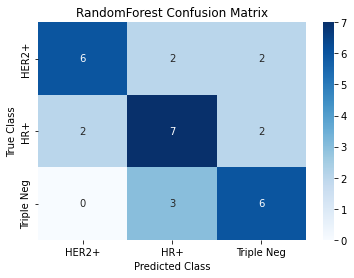

In [25]:
cf_matrix=metrics.confusion_matrix(y_test, test_svm_pred, labels=["HER2+", "HR+", "Triple Neg"])
s_rf = sns.heatmap(cf_matrix, annot= True, cmap='Blues', 
                   xticklabels = ["HER2+", "HR+", "Triple Neg"], yticklabels = ["HER2+", "HR+", "Triple Neg"])
b=s_rf.set(xlabel='Predicted Class', ylabel='True Class')
a=s_rf.set(title = 'RandomForest Confusion Matrix')

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

def LR_model(X, y, max_iter_list, penalty_list, tol_list, C_list):
    # Setup the Grid Search function with parameters given by the user
    grid_search = GridSearchCV(estimator = LogisticRegression(random_state = 0),
                              param_grid = {'max_iter': max_iter_list,
                                           'penalty': penalty_list,
                                           'tol': tol_list,
                                           'C': C_list,},
                              scoring = "accuracy",
                              verbose = 0,
                              cv = 5)
    # Run the grid search
    gs_results= grid_search.fit(X, y)
    # Get the best parameters
    gs_bp = gs_results.best_params_
    
    LR = LogisticRegression(max_iter = gs_bp["max_iter"],
                                penalty = gs_bp["penalty"],
                                tol = gs_bp["tol"],
                                C = gs_bp["C"],
                                random_state = 0,
                                verbose = False)
    # Get scores:
    scores = cross_val_score(LR, X, y, cv = 5, scoring = "accuracy")
    
    return gs_results, gs_bp, LR, scores

In [27]:
max_iter_list = [1000]
penalty_list = ['l1', 'l2', 'elasticnet', 'none']
tol_list = [.0001, .001, .01]
C_list2 = [.1, .2, .3, .4, .5]

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
%%time
gs_LR_results, gs_LR_bp, LR, LR_scores = LR_model(x_train, y_train, max_iter_list, penalty_list, 
                                              tol_list, C_list2)

Wall time: 10.4 s


In [30]:
print("Cross-validation accuracy: ") 
print(np.mean(LR_scores))

Cross-validation accuracy: 
0.6857142857142857


In [31]:
LR.fit(x_train,y_train)
                            
# Model Accuracy, how often is the classifier correct?
train_LR_pred=LR.predict(x_train)
# Evaluate training accuracy
test_LR_pred=LR.predict(x_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy training:",metrics.accuracy_score(y_train, train_LR_pred))
print("Accuracy testing:",metrics.accuracy_score(y_test, test_LR_pred))

Accuracy training: 1.0
Accuracy testing: 0.7666666666666667


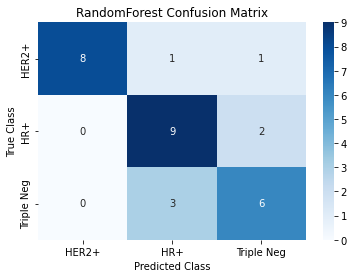

In [32]:
cf_matrix=metrics.confusion_matrix(y_test, test_LR_pred, labels=["HER2+", "HR+", "Triple Neg"])
s_rf = sns.heatmap(cf_matrix, annot= True, cmap='Blues', 
                   xticklabels = ["HER2+", "HR+", "Triple Neg"], yticklabels = ["HER2+", "HR+", "Triple Neg"])
b=s_rf.set(xlabel='Predicted Class', ylabel='True Class')
a=s_rf.set(title = 'RandomForest Confusion Matrix')